In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import os

In [2]:
df= pd.read_excel("Dataset_Public_mini.xlsx")

In [3]:
df['Claim Description'].head(10)

0    THE IV WAS MAKING A LEFT TURN ON A GREEN ARROW...
1    CLAIMANT ALLEGES SHE SUFFERED INJURIES IN AN E...
2    IV PASSENGER SUSTAINED INJURIES, OV AND IV COL...
3    CLAIMANT ALLEGES SHE WAS BURNED UNKNOWN DEGREE...
4    THE IV WAS MERGING INTO A CONSTRUCTION ZONE WH...
5    OV SITTING AT STOP LIGHT WAITING TO TURN WHEN ...
6    AT ABOUT 230 PM GAVIN CALLED STATING THAT WHIL...
7    MBR SLIPPED AND FELL ON A PUDDLE OF WATER IN C...
8    RECEIVED A CALL FROM JOANN ADKINS ABOUT HER FA...
9    CLAIMANT SUFFERED BODILY INJURY DUE TO PICKED ...
Name: Claim Description, dtype: object

In [6]:
def WCplot(cl):
    colData = df[cl]
    singletxt = ''
    for mem in colData:
        singletxt += str(mem)
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(singletxt)
    # Plot the word cloud
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #plt.savefig('temp/WCplot.png')
    plt.show()

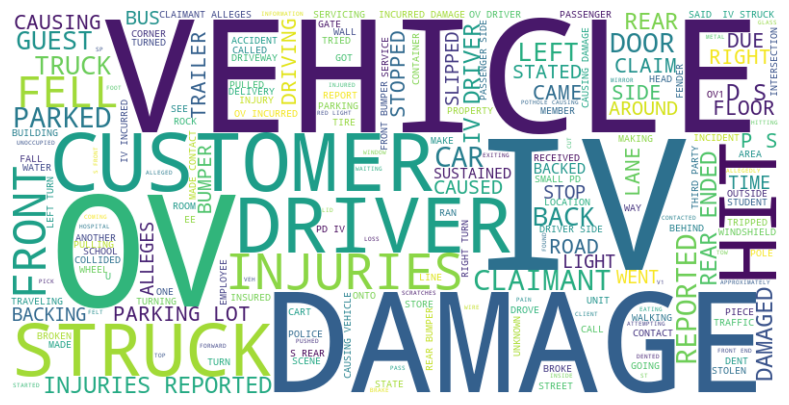

In [7]:
first_col = df.columns[0]
WCplot(first_col)

# Importing all the necessary libraries at once

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import spacy

In [9]:
nlp = spacy.load("en_core_web_sm")

# Preprocessing function using spaCy
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove digits
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)

# Apply preprocessing
df["Claim Description"] = df["Claim Description"].fillna("")
df["Claim Description"] = df["Claim Description"].apply(preprocess_text)

In [10]:
# Vectorization using TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(df["Claim Description"])

# Using preprocessing to scale down the data and then test the data

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, df["Accident Source"], test_size=0.3, random_state=57)

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

# Define the pipeline with scaling and resampling
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),  # Scale the data using MinMaxScaler
    ('over_sampler', RandomOverSampler()),  # Random oversampling
])

# Apply the pipeline to resample and scale the training data
X_train_resampled_scaled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [12]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_resampled_scaled, y_train_resampled)

MultinomialNB()

In [14]:
# Logistic Regression with Grid Search
param_grid_lr = {
    'C': [0.1, 1, 10, 100,500,700]
}
lr = LogisticRegression(max_iter=5)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train_resampled_scaled, y_train_resampled)
best_lr = grid_search_lr.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [15]:
best_lr

LogisticRegression(C=1, max_iter=5)

In [16]:
# Random Forest with Grid Search
param_grid_rf = {
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [17]:
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=2, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_resampled_scaled, y_train_resampled)
best_rf = grid_search_rf.best_estimator_

Fitting 2 folds for each of 144 candidates, totalling 288 fits


In [18]:
best_rf

RandomForestClassifier(min_samples_split=10, n_estimators=200)

In [19]:
# SVM with Grid Search
param_grid_svm = {
    'C': [0.1, 1, 10, 100,500],
    'kernel': ['linear', 'rbf']
}
svm = SVC()
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, verbose=2)

In [22]:
grid_search_svm.fit(X_train_resampled_scaled, y_train_resampled)
best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [23]:
best_svm

SVC(C=1, kernel='linear')

In [24]:
# Multilayer Perceptrons (MLP)
mlp = MLPClassifier()
mlp.fit(X_train_resampled_scaled, y_train_resampled)
mlp_predictions = mlp.predict(X_test)

In [25]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

In [62]:
# Evaluate models
print("Naive Bayes Performance:")
evaluate_model(nb, X_test, y_test)

print("\nLogistic Regression Performance:")
evaluate_model(best_lr, X_test, y_test)

print("\nRandom Forest Performance:")
evaluate_model(best_rf, X_test, y_test)

print("\nSVM Performance:")
evaluate_model(best_svm, X_test, y_test)

print("\nMultiLayer Perceptrons Performance:")
evaluate_model(mlp, X_test, y_test)

Naive Bayes Performance:
Accuracy: 0.22653721682847897

Logistic Regression Performance:
Accuracy: 0.31715210355987056

Random Forest Performance:
Accuracy: 0.35275080906148865

SVM Performance:
Accuracy: 0.3300970873786408

MultiLayer Perceptrons Performance:
Accuracy: 0.32362459546925565


# Testing the data now without preprocessing

In [29]:
from imblearn.ensemble import BalancedRandomForestClassifier
#Balanced Random Forest
BRFClassifier=BalancedRandomForestClassifier(n_estimators=250)
BRFClassifier.fit(X_train_resampled_scaled, y_train_resampled) 
BRF_predictions = BRFClassifier.predict(X_test)
print("Balanced Random Forest Score :")
BRFClassifier.score(X_test,y_test)

Balanced Random Forest Score :


0.20064724919093851

In [30]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [31]:
# Logistic Regression with Grid Search
param_grid_lr = {
    'C': [0.1, 1, 10, 100,500,700]
}
lr = LogisticRegression(max_iter=10)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [32]:
# Random Forest with Grid Search
param_grid_rf = {
    'n_estimators': [100, 200, 250, 300,350,400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [33]:
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=2, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

Fitting 2 folds for each of 216 candidates, totalling 432 fits


In [119]:
# SVM with Grid Search
param_grid_svm = {
    'C': [0.1, 1,5, 10, 100,500],
    'kernel': ['linear', 'rbf']
}
svm = SVC()
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, verbose=2)

In [120]:
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [36]:
# Multilayer Perceptrons (MLP)
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)

Text(0, 0.5, 'accuracy Rate')

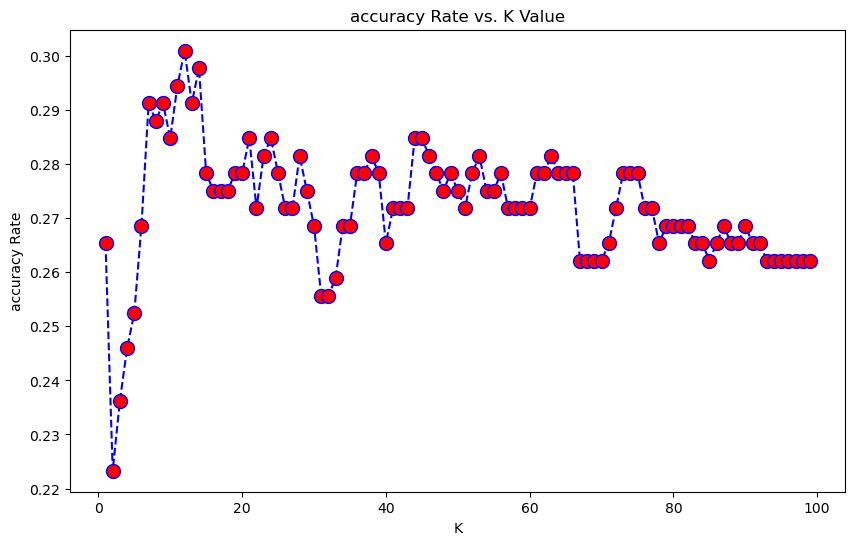

In [37]:
from sklearn import neighbors
accuracy_rate = []

# Will take some time
for i in range(1,100):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    accuracy_rate.append(np.mean(np.array(y_test) == pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('accuracy Rate')

In [114]:
from sklearn import neighbors
KNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=12, weights='distance')
KNNClassifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=12, weights='distance')

In [122]:
print("Naive Bayes Performance:")
evaluate_model(nb, X_test, y_test)

print("\nLogistic Regression Performance:")
evaluate_model(best_lr, X_test, y_test)

print("\nRandom Forest Performance:")
evaluate_model(best_rf, X_test, y_test)

print("\nSVM Performance:")
evaluate_model(best_svm, X_test, y_test)

print("\nMultiLayer Perceptrons Performance:")
evaluate_model(mlp, X_test, y_test)

print("\nKNN Performance:")
evaluate_model(KNNClassifier, X_test, y_test)

Naive Bayes Performance:
Accuracy: 0.22653721682847897

Logistic Regression Performance:
Accuracy: 0.31715210355987056

Random Forest Performance:
Accuracy: 0.35275080906148865

SVM Performance:
Accuracy: 0.3300970873786408

MultiLayer Perceptrons Performance:
Accuracy: 0.32362459546925565

KNN Performance:
Accuracy: 0.3042071197411003


In [123]:
pred_rf=[]
pred_svm=[]
for i in range (len(df)):
    sample_text_i = df['Claim Description'][i]
    sample_text_i = preprocess_text(sample_text_i)
    sample_text_i_vectorized = tfidf.transform([sample_text_i])
    pred_rf.append(best_rf.predict(sample_text_i_vectorized))
    pred_svm.append(best_svm.predict(sample_text_i_vectorized))

In [125]:
flattened_pred_rf=[i[0] for i in pred_rf]
flattened_pred_svm=[i[0] for i in pred_svm]
predi= pd.DataFrame({'Actual words':df['Claim Description'],'Actual Pred':df['Accident Source'],
                     'pred_RF':flattened_pred_rf,'pred_SVM':flattened_pred_svm})
predi

,Actual words,Actual Pred,pred_RF,pred_SVM
0,iv make left turn green arrow pedestrian run...,"Struck pedestrian, bicycle","Struck pedestrian, bicycle","Struck pedestrian, bicycle"
1,claimant allege suffer injury elevator,Elevator/Escalator,Elevator/Escalator,Elevator/Escalator
2,iv passenger sustain injury ov iv collide caus...,Sideswipe or lane change,Sideswipe or lane change,Sideswipe or lane change
3,claimant allege burn unknown degree hot tea ...,Food Product,Alleged Negligent Act,Alleged Negligent Act
4,iv merge construction zone rear end theov ov i...,Struck vehicle in rear,Struck vehicle in rear,Struck vehicle in rear
5,ov sit stop light wait turn iv ov,Struck vehicle in rear,Struck vehicle in rear,Struck vehicle in rear
6,pm gavin call state homepreforming service v...,Backed into vehicle or object,Backed into vehicle or object,Backed into vehicle or object
7,mbr slip fall puddle water clothing mbr ap...,Alleged improper maintenance - other,Alleged improper maintenance - other,Alleged improper maintenance - other
8,receive joann adkin fall pm entrance hot...,Alleged Negligent Act,Alleged Negligent Act,Alleged Negligent Act
9,claimant suffer bodily injury pick certain bag...,Fall - other falls,Not Otherwise Classified,Not Otherwise Classified


# Taking an example:

In [134]:
Claim= "ov hit iv"
print('Claim is: ', Claim, '\n')

Claim_i = preprocess_text(Claim)
Claim_i_vectorized = tfidf.transform([Claim_i])

print('According to Random Forest prediction: ', best_rf.predict(Claim_i_vectorized))
print('According to SVM prediction: ', best_svm.predict(Claim_i_vectorized))

Claim is:  ov hit iv 

According to Random Forest prediction:  ['Sideswipe or lane change']
According to SVM prediction:  ['Intersection accident']
